Usando mnist como dataset
Encontrados 6 pares de modelos.

🧩 Cargando modelos para configuración: 128_lat_2_mnist.keras

✅ Modelo '128_lat_2_mnist.keras' procesado.

🧩 Cargando modelos para configuración: 128_lat_64_mnist.keras
✅ Modelo '128_lat_64_mnist.keras' procesado.

🧩 Cargando modelos para configuración: 128_lat_64_mnist_beta_10.keras
✅ Modelo '128_lat_64_mnist_beta_10.keras' procesado.

🧩 Cargando modelos para configuración: 256_lat_128_mnist.keras
✅ Modelo '256_lat_128_mnist.keras' procesado.

🧩 Cargando modelos para configuración: 256_lat_64_mnist.keras
✅ Modelo '256_lat_64_mnist.keras' procesado.

🧩 Cargando modelos para configuración: 512_lat_256_mnist.keras
✅ Modelo '512_lat_256_mnist.keras' procesado.


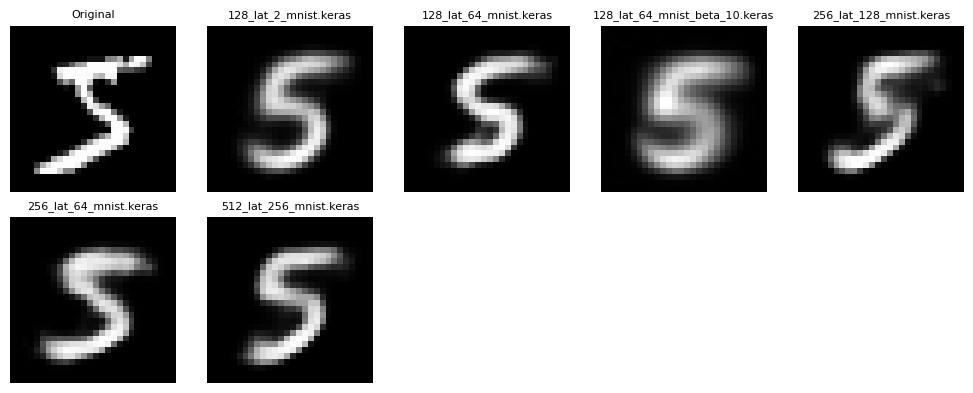

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Agregar carpeta raíz al path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))

# Importar módulos propios
from Datos.Data_acq import get_mnist_data
from models.cVAE import CVAE
from custom_layers.Sampling import Sampling

# Cargar datos
x_train, x_test, x_val, y_train, y_test, y_val, x_train_1, y_train_1 = get_mnist_data()

# Rutas a los modelos
ENCODER_DIR = "../../modelos_entrenados/encoders/"
DECODER_DIR = "../../modelos_entrenados/decoders/"
ORIGINAL_DIM = 28 * 28

# Obtener listas de archivos
encoder_files = sorted(os.listdir(ENCODER_DIR))
decoder_files = sorted(os.listdir(DECODER_DIR))

# Función para extraer clave
def get_key(filename):
    return "_".join(filename.split("_")[2:])  # ej: 'lat_2_mnist.keras'

# Crear diccionarios clave → path
encoders = {get_key(f): os.path.join(ENCODER_DIR, f) for f in encoder_files if f.endswith(".keras")}
decoders = {get_key(f): os.path.join(DECODER_DIR, f) for f in decoder_files if f.endswith(".keras")}

# Claves comunes entre encoder y decoder
common_keys = sorted(set(encoders.keys()) & set(decoders.keys()))
print(f"Encontrados {len(common_keys)} pares de modelos.")

# Imagen original
x_input = x_train[:1]         # Imagen original
cond_input = y_train[:1]      # Condición
original_image = x_input[0].reshape(28, 28)

# Guardar imágenes reconstruidas + nombres
reconstructed_images = [original_image]
model_names = ["Original"]

# Iterar sobre modelos
for key in common_keys:
    print(f"\n🧩 Cargando modelos para configuración: {key}")
    
    encoder_path = encoders[key]
    decoder_path = decoders[key]
    
    encoder = load_model(encoder_path, custom_objects={"Sampling": Sampling})
    decoder = load_model(decoder_path)

    cvae = CVAE(encoder, decoder, original_dim=ORIGINAL_DIM)
    cvae.compile(optimizer="adam")

    # Codificar y decodificar
    z_mean, z_log_var, z = cvae.encoder.predict([x_input, cond_input],verbose=0)
    reconstructed = cvae.decoder.predict([z, cond_input],verbose=0)

    # Guardar imagen
    reconstructed_images.append(reconstructed[0].reshape(28, 28))
    model_names.append(key)

    print(f"✅ Modelo '{key}' procesado.")

# Mostrar todas las imágenes en una sola figura
num_images = len(reconstructed_images)
cols = min(5, num_images)
rows = (num_images + cols - 1) // cols

plt.figure(figsize=(cols * 2, rows * 2))

for i, (img, name) in enumerate(zip(reconstructed_images, model_names)):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img, cmap="gray")
    plt.title(name, fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()
